<a href="https://colab.research.google.com/github/Zerberuz/evaluaciones_python_202520/blob/main/Evaluacion5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EVALUACIÓN 5: REGRESIÓN LINEAL MÚLTIPLE PARA PREDICCIÓN DE ENERGÍA SOLAR**
=

**Universidad Pontificia Bolivariana - Seccional Montería**

**Facultad de Ingeniería Electrónica - Python Aplicado a la Ingeniería**

Descripción:Sistema de predicción de producción de energía fotovoltaica mediante regresión lineal múltiple, comparando dos ubicaciones geográficas.

Autores: Camilo Ernesto Calderin Ogaza, Elizabeth Hosten

Fecha: 08 Octubre 2025



EVALUACIÓN 5: MODELO PREDICTIVO CON REGRESIÓN LINEAL MÚLTIPLE

MODELO DE REGRESIÓN LINEAL MÚLTIPLE - DUBAI

División de datos:
  • Total: 8760 registros
  • Entrenamiento: 7008 (80%)
  • Prueba: 1752 (20%)

Intercepto (β₀): 0.009032 kW

Coeficientes:
  β1 (GHI                 ):     0.000451
  β2 (DHI                 ):     0.000093
  β3 (DNI                 ):     0.000066
  β4 (Temperature         ):    -0.000316
  β5 (Hour_Local          ):     0.000016
  β6 (Month               ):    -0.000088

Métrica                   Entrenamiento   Prueba         
-------------------------------------------------------
R²                        0.9995          0.9995         
MAE (kW)                  0.002711        0.002717       
RMSE (kW)                 0.003803        0.003770       

→ El modelo explica el 99.95% de la variabilidad
→ Error promedio absoluto: 2.72 W

   Variable  Coeficiente  Importancia_%
        GHI     0.000451      43.777205
Temperature    -0.000316      30.698406
  

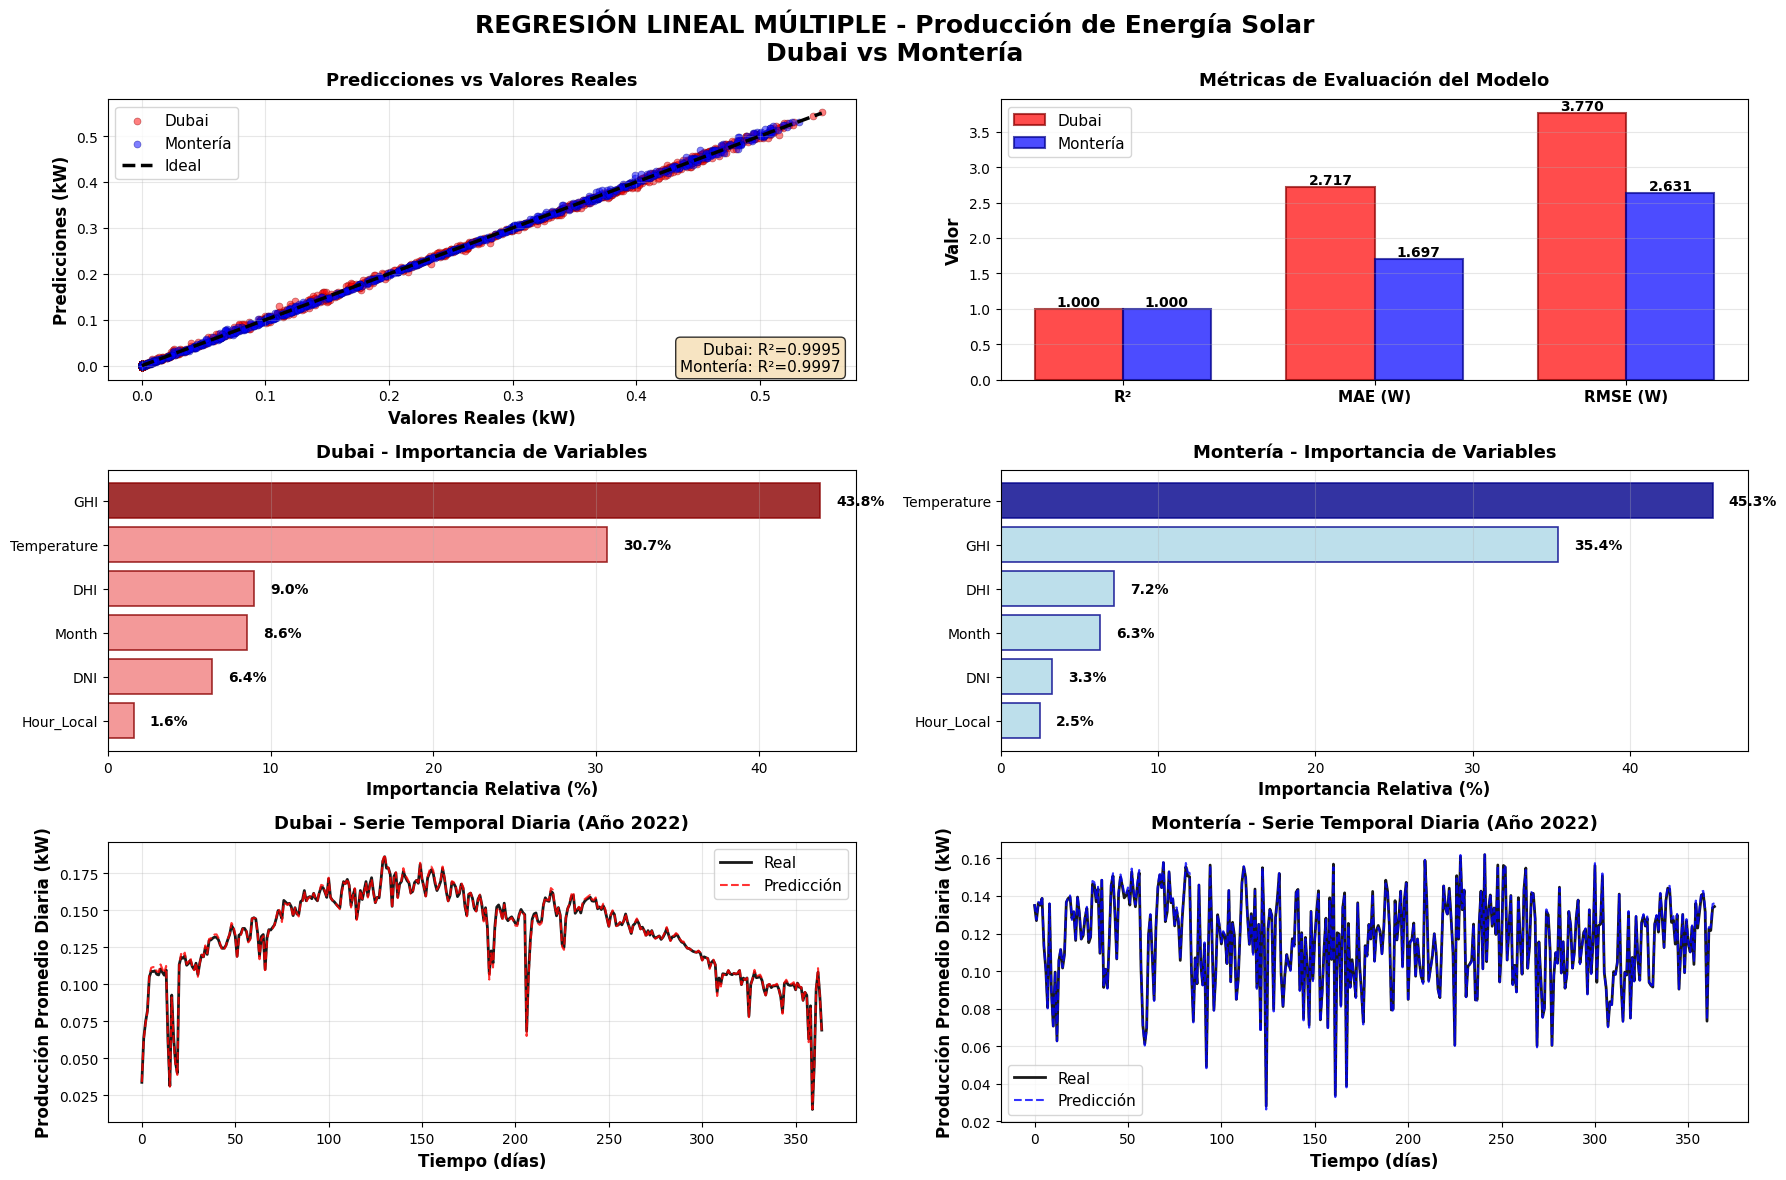

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# MODELO FÍSICO (POO - Evaluación anterior)
class PanelSolarFotovoltaico:
    def __init__(self):
        self.potencia_nominal = 0.54  # kW
        self.area_panel = 2.79  # m²
        self.eficiencia_stc = 0.217  # 21.7% en condiciones STC
        self.tecnologia = "Monocristalino PERC"
        self.coef_temperatura = -0.0035  # -0.35%/°C
        self.temp_nominal_operacion = 45.0  # °C (NOCT)
        self.temp_stc = 25.0  # °C
    def calcular_temperatura_celda(self, temperatura_ambiente, irradiancia):
        temp_celda = temperatura_ambiente + ((self.temp_nominal_operacion - 20) / 800) * irradiancia
        return temp_celda
    def calcular_eficiencia_real(self, temperatura_celda):
        factor_temp = 1 + self.coef_temperatura * (temperatura_celda - self.temp_stc)
        eficiencia_real = self.eficiencia_stc * factor_temp
        return max(0, eficiencia_real)
    def calcular_produccion(self, irradiancia, temperatura_ambiente):
        if irradiancia <= 0:
            return 0.0
        temp_celda = self.calcular_temperatura_celda(temperatura_ambiente, irradiancia)
        eficiencia_real = self.calcular_eficiencia_real(temp_celda)
        potencia = (irradiancia / 1000) * self.area_panel * eficiencia_real  # kW
        return potencia

# PREPARACIÓN DE DATOS
def cargar_y_preparar_datos(archivo_csv, ubicacion):
    df = pd.read_csv(archivo_csv)
    if ubicacion.lower() == 'dubai':
        offset = 4
    elif ubicacion.lower() == 'monteria':
        offset = -5
    else:
        offset = 0
    df['Hour_Local'] = (df['Hour'] + offset) % 24
    panel = PanelSolarFotovoltaico()
    produccion_real = []
    for _, row in df.iterrows():
        prod = panel.calcular_produccion(row['GHI'], row['Temperature'])
        produccion_real.append(prod)
    df['Produccion_Real_kW'] = np.array(produccion_real)
    return df

# MODELO PREDICTIVO (Regresión Lineal)
def crear_modelo_regresion(df, ubicacion, test_size=0.2):
    print(f"\n{'='*80}")
    print(f"MODELO DE REGRESIÓN LINEAL MÚLTIPLE - {ubicacion.upper()}")
    print(f"{'='*80}")

    columnas_x = ['GHI', 'DHI', 'DNI', 'Temperature', 'Hour_Local', 'Month']
    if 'Relative_Humidity' in df.columns:
        columnas_x.append('Relative_Humidity')

    x = df[columnas_x]
    y = df['Produccion_Real_kW']

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=42
    )

    print(f"\nDivisión de datos:")
    print(f"  • Total: {len(df)} registros")
    print(f"  • Entrenamiento: {len(x_train)} ({(1-test_size)*100:.0f}%)")
    print(f"  • Prueba: {len(x_test)} ({test_size*100:.0f}%)")

    modelo = LinearRegression()
    modelo.fit(x_train, y_train)

    y_train_pred = modelo.predict(x_train)
    y_test_pred = modelo.predict(x_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"\nIntercepto (β₀): {modelo.intercept_:.6f} kW")
    print("\nCoeficientes:")
    for i, col in enumerate(columnas_x):
        print(f"  β{i+1} ({col:20s}): {modelo.coef_[i]:>12.6f}")
    print(f"\n{'Métrica':<25} {'Entrenamiento':<15} {'Prueba':<15}")
    print("-" * 55)
    print(f"{'R²':<25} {r2_train:<15.4f} {r2_test:<15.4f}")
    print(f"{'MAE (kW)':<25} {mae_train:<15.6f} {mae_test:<15.6f}")
    print(f"{'RMSE (kW)':<25} {rmse_train:<15.6f} {rmse_test:<15.6f}")
    print(f"\n→ El modelo explica el {r2_test*100:.2f}% de la variabilidad")
    print(f"→ Error promedio absoluto: {mae_test*1000:.2f} W")

    importancia = pd.DataFrame({
        'Variable': columnas_x,
        'Coeficiente': modelo.coef_,
        'Importancia_Abs': np.abs(modelo.coef_)
    }).sort_values('Importancia_Abs', ascending=False)
    suma_abs = importancia['Importancia_Abs'].sum()
    importancia['Importancia_%'] = (importancia['Importancia_Abs'] / suma_abs) * 100

    print("\n" + importancia[['Variable', 'Coeficiente', 'Importancia_%']].to_string(index=False))
    y_all_pred = modelo.predict(x)
    df['Prediccion_Regresion_kW'] = y_all_pred
    df['Error_Regresion'] = df['Produccion_Real_kW'] - df['Prediccion_Regresion_kW']
    return {
        'modelo': modelo,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'df': df,
        'columnas_x': columnas_x,
        'importancia': importancia,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

# ANÁLISIS INTERPRETATIVO
def analisis_interpretativo(resultados_dubai, resultados_monteria):
    print(f"\n{'='*80}")
    print(f"ANÁLISIS INTERPRETATIVO")
    print(f"{'='*80}")
    print(f"\n1. ¿QUÉ VARIABLE PESA MÁS EN CADA CASO?")
    print(f"\n   DUBAI:")
    var_dubai = resultados_dubai['importancia'].iloc[0]
    print(f"   → Variable dominante: {var_dubai['Variable']}")
    print(f"   → Importancia relativa: {var_dubai['Importancia_%']:.2f}%")
    print(f"   → Coeficiente: {var_dubai['Coeficiente']:.6f}")
    print(f"\n   MONTERÍA:")
    var_monteria = resultados_monteria['importancia'].iloc[0]
    print(f"   → Variable dominante: {var_monteria['Variable']}")
    print(f"   → Importancia relativa: {var_monteria['Importancia_%']:.2f}%")
    print(f"   → Coeficiente: {var_monteria['Coeficiente']:.6f}")
    print(f"\n2. ¿QUÉ TAN AJUSTADO ESTÁ EL MODELO EN CADA LUGAR?")
    print(f"\n   DUBAI:")
    print(f"   → R² = {resultados_dubai['r2_test']:.4f} ({resultados_dubai['r2_test']*100:.2f}%)")
    print(f"   → Error promedio: {resultados_dubai['mae_test']*1000:.2f} W")
    print(f"\n   MONTERÍA:")
    print(f"   → R² = {resultados_monteria['r2_test']:.4f} ({resultados_monteria['r2_test']*100:.2f}%)")
    print(f"   → Error promedio: {resultados_monteria['mae_test']*1000:.2f} W")
    print(f"\n3. COMPARACIÓN ENTRE UBICACIONES:")
    if abs(resultados_dubai['r2_test'] - resultados_monteria['r2_test']) < 0.02:
        print(f"   → Ambos modelos tienen ajuste similar")
    elif resultados_dubai['r2_test'] > resultados_monteria['r2_test']:
        diferencia = (resultados_dubai['r2_test'] - resultados_monteria['r2_test']) * 100
        print(f"   → El modelo de Dubai tiene mejor ajuste")
        print(f"   → Diferencia: {diferencia:.2f} puntos porcentuales")
    else:
        diferencia = (resultados_monteria['r2_test'] - resultados_dubai['r2_test']) * 100
        print(f"   → El modelo de Montería tiene mejor ajuste")
        print(f"   → Diferencia: {diferencia:.2f} puntos porcentuales")

# GRÁFICAS
def crear_graficas_esenciales(resultados_dubai, resultados_monteria):
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle('REGRESIÓN LINEAL MÚLTIPLE - Producción de Energía Solar\nDubai vs Montería',
                 fontsize=18, fontweight='bold', y=0.98)

    #grafica 1: PREDICCIONES VS VALORES REALES
    ax1 = plt.subplot(3, 2, 1)
    ax1.scatter(resultados_dubai['y_test'], resultados_dubai['y_test_pred'],
               alpha=0.5, s=25, color='red', label='Dubai', edgecolors='darkred', linewidth=0.5)
    ax1.scatter(resultados_monteria['y_test'], resultados_monteria['y_test_pred'],
               alpha=0.5, s=25, color='blue', label='Montería', edgecolors='darkblue', linewidth=0.5)
    min_val = min(resultados_dubai['y_test'].min(), resultados_monteria['y_test'].min())
    max_val = max(resultados_dubai['y_test'].max(), resultados_monteria['y_test'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2.5, label='Ideal')
    ax1.set_xlabel('Valores Reales (kW)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicciones (kW)', fontsize=12, fontweight='bold')
    ax1.set_title('Predicciones vs Valores Reales', fontsize=13, fontweight='bold', pad=10)
    ax1.legend(fontsize=11, loc='upper left')
    ax1.grid(True, alpha=0.3)
    text_str = f"Dubai: R²={resultados_dubai['r2_test']:.4f}\nMontería: R²={resultados_monteria['r2_test']:.4f}"
    ax1.text(0.98, 0.02, text_str, transform=ax1.transAxes, fontsize=11,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    #grafica 2: MÉTRICAS
    ax2 = plt.subplot(3, 2, 2)
    metricas = ['R²', 'MAE (W)', 'RMSE (W)']
    dubai_vals = [resultados_dubai['r2_test'],
                  resultados_dubai['mae_test']*1000,
                  resultados_dubai['rmse_test']*1000]
    monteria_vals = [resultados_monteria['r2_test'],
                     resultados_monteria['mae_test']*1000,
                     resultados_monteria['rmse_test']*1000]
    x = np.arange(len(metricas))
    width = 0.35
    bars1 = ax2.bar(x - width/2, dubai_vals, width, label='Dubai',
                    color='red', alpha=0.7, edgecolor='darkred', linewidth=1.5)
    bars2 = ax2.bar(x + width/2, monteria_vals, width, label='Montería',
                    color='blue', alpha=0.7, edgecolor='darkblue', linewidth=1.5)
    ax2.set_ylabel('Valor', fontsize=12, fontweight='bold')
    ax2.set_title('Métricas de Evaluación del Modelo', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xticks(x)
    ax2.set_xticklabels(metricas, fontsize=11, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    #grafica 3: IMPORTANCIA DE VARIABLES
    ax3 = plt.subplot(3, 2, 3)
    imp_dubai = resultados_dubai['importancia'].sort_values('Importancia_%', ascending=True)
    colors = ['darkred' if x == imp_dubai['Importancia_%'].max() else 'lightcoral'
              for x in imp_dubai['Importancia_%']]
    ax3.barh(imp_dubai['Variable'], imp_dubai['Importancia_%'],
            color=colors, alpha=0.8, edgecolor='darkred', linewidth=1.2)
    ax3.set_xlabel('Importancia Relativa (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Dubai - Importancia de Variables', fontsize=13, fontweight='bold', pad=10)
    ax3.grid(True, alpha=0.3, axis='x')
    for i, (var, val) in enumerate(zip(imp_dubai['Variable'], imp_dubai['Importancia_%'])):
        ax3.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=10, fontweight='bold')
    ax4 = plt.subplot(3, 2, 4)
    imp_monteria = resultados_monteria['importancia'].sort_values('Importancia_%', ascending=True)
    colors = ['darkblue' if x == imp_monteria['Importancia_%'].max() else 'lightblue'
              for x in imp_monteria['Importancia_%']]
    ax4.barh(imp_monteria['Variable'], imp_monteria['Importancia_%'],
            color=colors, alpha=0.8, edgecolor='darkblue', linewidth=1.2)
    ax4.set_xlabel('Importancia Relativa (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Montería - Importancia de Variables', fontsize=13, fontweight='bold', pad=10)
    ax4.grid(True, alpha=0.3, axis='x')
    for i, (var, val) in enumerate(zip(imp_monteria['Variable'], imp_monteria['Importancia_%'])):
        ax4.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=10, fontweight='bold')

    #grafica 4: SERIES TEMPORALES DIARIAS (24 horas promedio)
    ax5 = plt.subplot(3, 2, 5)
    # Agrupar datos por día (promedio de las 24 horas)
    df_d = resultados_dubai['df'].copy()
    df_d['Dia'] = df_d.index // 24  # Cada 24 horas = 1 día
    df_d_diario = df_d.groupby('Dia').agg({
        'Produccion_Real_kW': 'mean',
        'Prediccion_Regresion_kW': 'mean'
    }).reset_index()
    ax5.plot(df_d_diario['Dia'], df_d_diario['Produccion_Real_kW'],
            label='Real', color='black', linewidth=2, alpha=0.9)
    ax5.plot(df_d_diario['Dia'], df_d_diario['Prediccion_Regresion_kW'],
            label='Predicción', color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    ax5.set_xlabel('Tiempo (días)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Producción Promedio Diaria (kW)', fontsize=12, fontweight='bold')
    ax5.set_title('Dubai - Serie Temporal Diaria (Año 2022)', fontsize=13, fontweight='bold', pad=10)
    ax5.legend(fontsize=11)
    ax5.grid(True, alpha=0.3)
    ax6 = plt.subplot(3, 2, 6)

    #Datos por día
    df_m = resultados_monteria['df'].copy()
    df_m['Dia'] = df_m.index // 24
    df_m_diario = df_m.groupby('Dia').agg({
        'Produccion_Real_kW': 'mean',
        'Prediccion_Regresion_kW': 'mean'
    }).reset_index()
    ax6.plot(df_m_diario['Dia'], df_m_diario['Produccion_Real_kW'],
            label='Real', color='black', linewidth=2, alpha=0.9)
    ax6.plot(df_m_diario['Dia'], df_m_diario['Prediccion_Regresion_kW'],
            label='Predicción', color='blue', linewidth=1.5, linestyle='--', alpha=0.8)
    ax6.set_xlabel('Tiempo (días)', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Producción Promedio Diaria (kW)', fontsize=12, fontweight='bold')
    ax6.set_title('Montería - Serie Temporal Diaria (Año 2022)', fontsize=13, fontweight='bold', pad=10)
    ax6.legend(fontsize=11)
    ax6.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('graficas_evaluacion5.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("\n" + "="*80)
    print("EVALUACIÓN 5: MODELO PREDICTIVO CON REGRESIÓN LINEAL MÚLTIPLE")
    print("="*80)
    archivo_dubai = 'dubai_2022.csv'
    archivo_monteria = 'monteria_2022.csv'
    try:
        # DUBAI
        df_dubai = cargar_y_preparar_datos(archivo_dubai, 'dubai')
        resultados_dubai = crear_modelo_regresion(df_dubai, 'Dubai')

        # MONTERÍA
        df_monteria = cargar_y_preparar_datos(archivo_monteria, 'monteria')
        resultados_monteria = crear_modelo_regresion(df_monteria, 'Montería')

        # ANÁLISIS INTERPRETATIVO
        analisis_interpretativo(resultados_dubai, resultados_monteria)

        # GRÁFICAS
        crear_graficas_esenciales(resultados_dubai, resultados_monteria)

    except Exception as e:
        import traceback
        traceback.print_exc()